/data2/Gaurav/Babu/Langchain/lang/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Max tokens: 5420
Min tokens: 36
Avg tokens: 470.03


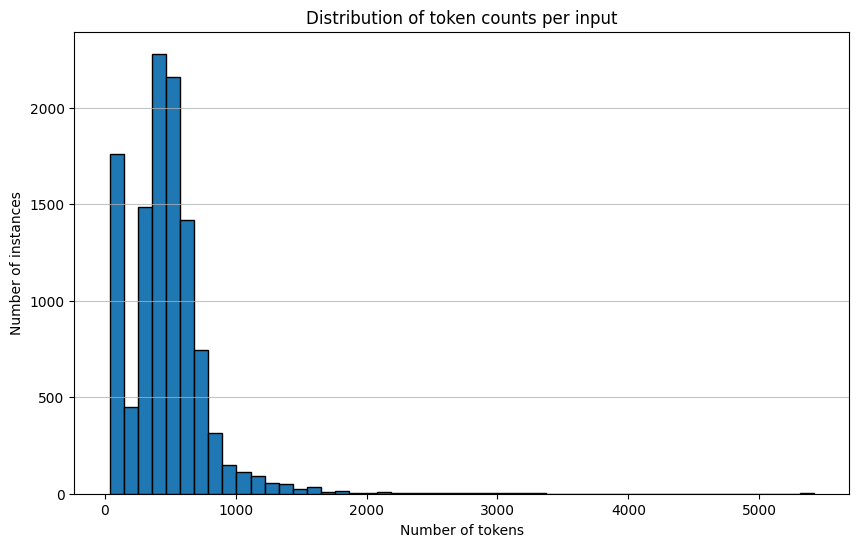

In [1]:
import json
from statistics import mean
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# Load tokenizer for LLaMA-8B
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")

# Load dataset
with open("../LLaMA-Factory/data/ru22fact_train_data_with_llm_retrieved_evidence.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Count tokens for each "input"
token_counts = []
for item in data:
    text = item["input"]
    tokens = tokenizer.encode(text, add_special_tokens=False)
    token_counts.append(len(tokens))

# Compute stats
max_tokens = max(token_counts)
min_tokens = min(token_counts)
avg_tokens = mean(token_counts)

print(f"Max tokens: {max_tokens}")
print(f"Min tokens: {min_tokens}")
print(f"Avg tokens: {avg_tokens:.2f}")

# --- Plot histogram ---
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, edgecolor="black")  # adjust bins as needed
plt.xlabel("Number of tokens")
plt.ylabel("Number of instances")
plt.title("Distribution of token counts per input")
plt.grid(axis="y", alpha=0.75)
plt.show()



In [4]:
!pip install matplotlib


  Using cached matplotlib-3.10.6-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.6-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (355 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 42.9 MB/s eta 0:00:00
Using cached kiwisolver-1.4.9-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (1.4 MB)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import json
import asyncio
import argparse
import pandas as pd
from typing import List, Dict, Union
from crawl4ai import (
    AsyncWebCrawler,
    CrawlerRunConfig,
    CacheMode,
    DefaultMarkdownGenerator,
    PruningContentFilter,
)
import nest_asyncio
nest_asyncio.apply()

from crawl4ai.async_dispatcher import MemoryAdaptiveDispatcher
from crawl4ai import RateLimiter
from tqdm import tqdm
from pathlib import Path
from loguru import logger

# from multilingual_factchecking.config import RAW_DATA_DIR, INTERIM_DATA_DIR
async def process_claim_with_links(
    claim: str, label: str, language: str, links: List[str], semaphore: asyncio.Semaphore
) -> Dict:
    """Crawl evidence links and return structured claim data."""
    async with semaphore:  # global concurrency limiter
        claim_data = {"claim": claim, "label": label, "language": language, "sources": []}

        prune_filter = PruningContentFilter(
            threshold=0.45, threshold_type="dynamic", min_word_threshold=5
        )
        md_generator = DefaultMarkdownGenerator(content_filter=prune_filter)
        run_config = CrawlerRunConfig(
            markdown_generator=md_generator, cache_mode=CacheMode.BYPASS
        )

        valid_urls = [url for url in links if isinstance(url, str) and url.startswith("http")]
        if not valid_urls:
            return claim_data

        dispatcher = MemoryAdaptiveDispatcher(
            memory_threshold_percent=90.0,
            check_interval=1.0,
            max_session_permit=5,
            rate_limiter=RateLimiter(base_delay=(1.0, 2.0), max_delay=30.0, max_retries=1),
        )

        async with AsyncWebCrawler() as crawler:
            results = await crawler.arun_many(
                urls=valid_urls, config=run_config, dispatcher=dispatcher
            )
            for result in results:
                if result.success and result.markdown.fit_markdown:
                    claim_data["sources"].append(
                        {"source": result.url, "content": result.markdown.fit_markdown}
                    )
                else:
                    logger.warning(f"Failed to crawl {result.url}: {result.error_message}")

        return claim_data


def normalize_row(row: pd.Series, dataset_type: str) -> Dict[str, Union[str, List[str]]]:
    """Normalize row into standard schema regardless of dataset type."""
    if dataset_type == "xfact":
        claim = row.get("claim", "")
        label = row.get("label", "NOT_SPECIFIED")
        language = row.get("language", "unknown")
        links = [row.get(f"link_{i}") for i in range(1, 6)]
    elif dataset_type == "ru22fact":
        claim = row.get("claim", "")
        label = row.get("label", "NOT_SPECIFIED")
        language = row.get("language", "unknown")
        links = [row.get("url")] if pd.notna(row.get("url")) else []
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")

    return {"claim": claim, "label": label, "language": language, "links": links}
 # import from your crawler code


def get_missing_claims(raw_file: Path, output_file: Path, dataset_type: str) -> pd.DataFrame:
    """Identify claims in raw dataset not present in output file."""

    # Load dataset
    if dataset_type == "xfact":
        df = pd.read_csv(raw_file, sep="\t", quoting=3, on_bad_lines="skip")
    elif dataset_type == "ru22fact":
        df = pd.read_csv(raw_file)
    else:
        raise ValueError(f"Unsupported dataset type: {dataset_type}")

    # Collect already processed claims
    processed_claims = set()
    if os.path.exists(output_file):
        with open(output_file, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    processed_claims.add(data["claim"])
                except:
                    continue

    # Filter missing claims
    missing = df[~df["claim"].isin(processed_claims)]
    logger.info(f"Found {len(missing)} missing claims out of {len(df)} total")
    return missing


async def crawl_missing_claims(
    raw_file: Path,
    output_file: Path,
    dataset_type: str,
    batch_size: int = 10,
    max_concurrency: int = 50,
):
    """Crawl only missing claims and append them to the output file."""
    missing_df = get_missing_claims(raw_file, output_file, dataset_type)
    rows = [normalize_row(row, dataset_type) for _, row in missing_df.iterrows()]

    semaphore = asyncio.Semaphore(max_concurrency)

    with open(output_file, "a", encoding="utf-8") as f:
        for i in range(0, len(rows), batch_size):
            batch = rows[i : i + batch_size]
            tasks = [
                process_claim_with_links(r["claim"], r["label"], r["language"], r["links"], semaphore)
                for r in batch
            ]
            results = await asyncio.gather(*tasks, return_exceptions=True)

            for claim_entry in results:
                if isinstance(claim_entry, Exception):
                    logger.error(f"Batch error: {claim_entry}")
                    continue
                json.dump(claim_entry, f, ensure_ascii=False)
                f.write("\n")
                f.flush()



dataset_type = "ru22fact"  # or "ru22fact"
split = "train"         # change to "dev" or "test" if needed

if dataset_type == "xfact":
    raw_file = RAW_DATA_DIR / dataset_type / f"{split}.tsv"
else:
    raw_file = "../data/raw/ru22fact/test.csv"

output_file = "../data/interim/ru22fact/ru22fact_test_with_webdata.jsonl"

asyncio.run(crawl_missing_claims(raw_file, output_file, dataset_type))



2025-09-30 10:43:37.520 | INFO     | __main__:get_missing_claims:108 - Found 0 missing claims out of 3216 total


In [2]:
!pip install loguru

  Using cached loguru-0.7.3-py3-none-any.whl.metadata (22 kB)
Using cached loguru-0.7.3-py3-none-any.whl (61 kB)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import json
import pandas as pd
from pathlib import Path

def merge_chinese_claims_with_evidence(raw_file: str, 
                                       output_file: str, 
                                       final_file: str, 
                                       dataset_type: str = "ru22fact"):
    """
    Merge evidence links from raw dataset into output dataset,
    only for Chinese claims, and save into a new file.
    """

    # --- Load raw dataset ---
    if dataset_type == "xfact":
        df = pd.read_csv(raw_file, sep="\t", quoting=3, on_bad_lines="skip")
    elif dataset_type == "ru22fact":
        df = pd.read_csv(raw_file)
    else:
        raise ValueError(f"Unsupported dataset type: {dataset_type}")

    # Keep only Chinese claims
    chinese_df = df[df["language"] == "zh"].copy()

    # Build lookup: claim -> links
    raw_evidence_map = {}
    for _, row in chinese_df.iterrows():
        if dataset_type == "xfact":
            links = [row.get(f"link_{i}") for i in range(1, 6) if pd.notna(row.get(f"link_{i}"))]
        elif dataset_type == "ru22fact":
            links = [row["url"]] if pd.notna(row.get("url")) else []
        raw_evidence_map[row["claim"]] = links

    # --- Load output dataset ---
    merged = []
    with open(output_file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                data = json.loads(line)
            except json.JSONDecodeError:
                continue

            claim = data.get("claim")
            if claim in raw_evidence_map:
                # Add raw dataset evidence under a new key
                data["raw_evidences"] = raw_evidence_map[claim]
            merged.append(data)

    # --- Save final merged dataset ---
    Path(final_file).parent.mkdir(parents=True, exist_ok=True)
    with open(final_file, "w", encoding="utf-8") as f:
        for item in merged:
            json.dump(item, f, ensure_ascii=False)
            f.write("\n")

    print(f"✅ Final dataset with Chinese claims saved to: {final_file}")
    print(f"ℹ️ Total entries: {len(merged)}")
    print(f"ℹ️ Chinese claims with evidences merged: {len(raw_evidence_map)}")


# Example usage:
raw_file = "../data/raw/ru22fact/test.csv"
output_file = "../data/interim/ru22fact/ru22fact_test_with_webdata.jsonl"
final_file = "../data/external/ru22fact/ru22fact_test_with_webdata_chinese.jsonl"

merge_chinese_claims_with_evidence(raw_file, output_file, final_file, dataset_type="ru22fact")


✅ Final dataset with Chinese claims saved to: ../data/external/ru22fact/ru22fact_test_with_webdata_chinese.jsonl
ℹ️ Total entries: 3212
ℹ️ Chinese claims with evidences merged: 0


In [2]:
import json
import pandas as pd

# Paths to your files
jsonl_path = "../data/processed/ru22fact/ru22fact_test_with_semantic_level_chunked_retrieved_evidence.jsonl"
csv_path = "../data/raw/ru22fact/test.csv"
output_path = "ru22fact_test_with_semantic_level_chunked_retrieved_evidence.jsonl"

# Load JSONL
with open(jsonl_path, "r", encoding="utf-8") as f:
    jsonl_data = [json.loads(line) for line in f]

# Load CSV
csv_data = pd.read_csv(csv_path)

# Create lookup dict from CSV (claim → row)
csv_lookup = {row["claim"]: row for _, row in csv_data.iterrows()}

# Update JSONL entries
for entry in jsonl_data:
    if entry.get("language") == "Chinese":
        claim = entry["claim"]
        if claim in csv_lookup:
            row = csv_lookup[claim]
            # Replace evidences
            entry["evidences"] = [{
                "source_index": 0,
                "source_url": row["url"],
                "evidence": row["evidence"]
            }]

# Save updated JSONL
with open(output_path, "w", encoding="utf-8") as f:
    for entry in jsonl_data:
        f.write(json.dumps(entry, ensure_ascii=False) + "\n")


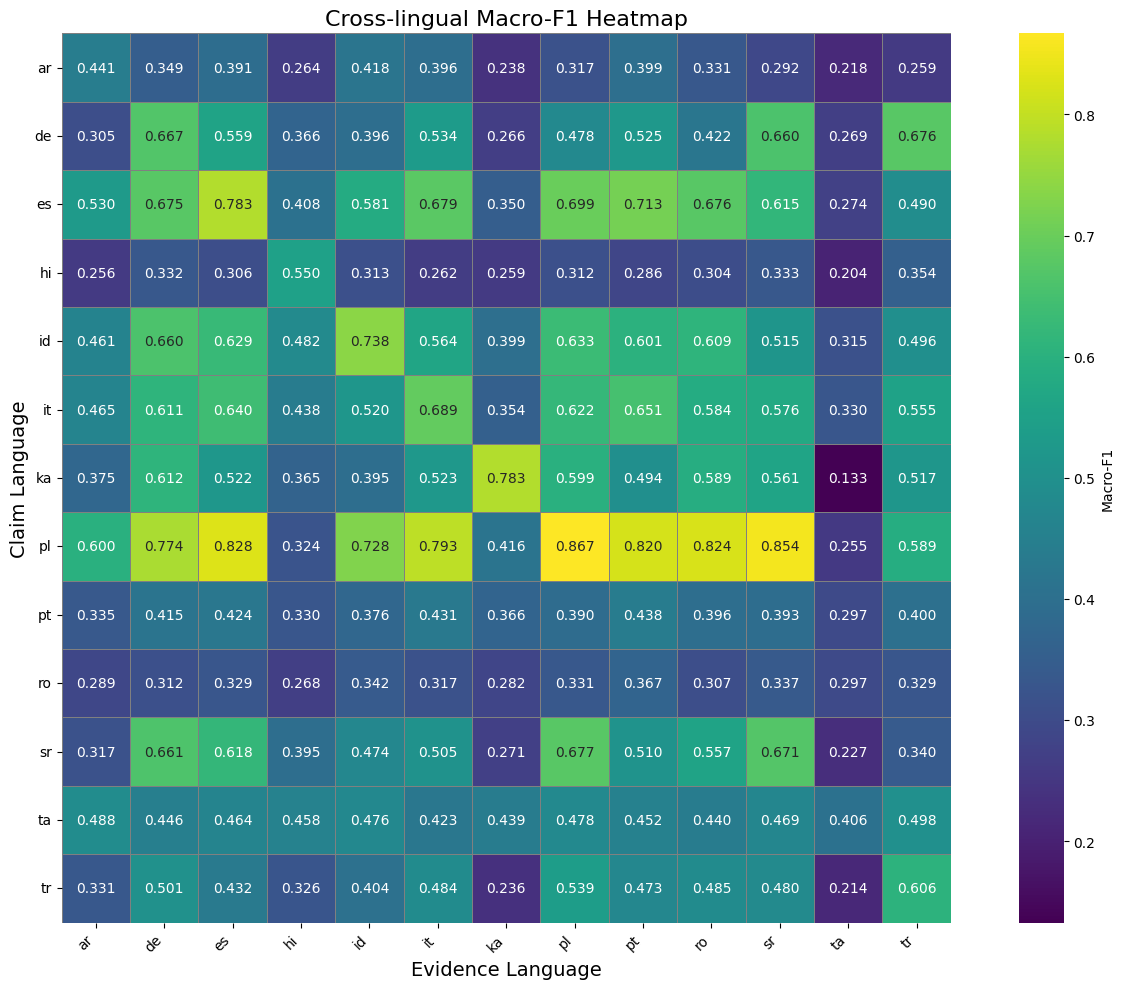

In [ ]:
import os
import re
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_heatmap(scores, title="Cross-lingual Macro-F1 Heatmap"):
    """
    scores: dict of dict, example:
        {
            "hi": {"original": 0.72, "tr": 0.68},
            "tr": {"original": 0.70, "de": 0.61},
        }
    """

    # Collect sorted unique languages
    claim_langs = sorted(scores.keys())            # row order
    evidence_langs = sorted(
        {ev for row in scores.values() for ev in row.keys()}
    )                                              # column order

    # Build matrix
    matrix = []
    for cl in claim_langs:
        row_vals = []
        for ev in evidence_langs:
            row_vals.append(scores[cl].get(ev, np.nan))
        matrix.append(row_vals)

    # Convert to DataFrame
    df = pd.DataFrame(matrix, index=claim_langs, columns=evidence_langs)

    plt.figure(figsize=(14, 10))

    ax = sns.heatmap(
        df,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={'label': 'Macro-F1'},
        square=True
    )

    plt.title(title, fontsize=16)
    plt.xlabel("Evidence Language", fontsize=14)
    plt.ylabel("Claim Language", fontsize=14)

    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()


# --------------------------
# Example usage
# --------------------------

# After running extraction:
# scores = collect_macro_f1_scores(base_dir)

# Plot
# plot_heatmap(scores)

def extract_macro_f1(text):
    """
    Robust extraction of macro-F1 from classification_report text.
    Handles arbitrary spacing and indentation.
    """
    for line in text.splitlines():
        stripped = line.strip().lower()
        if stripped.startswith("macro avg"):
            
            # Extract only numbers from the line
            nums = []
            for token in line.replace(",", " ").split():
                # accept floats like 0.5444
                try:
                    nums.append(float(token))
                except ValueError:
                    continue

            # nums = [precision, recall, f1, support]
            if len(nums) >= 3:
                return nums[2]  # F1-score

    return None


def collect_macro_f1_scores(base_dir):
    """
    Walk through directory and collect macro-F1 from metric files.

    base_dir example:
        outputs/xfact/Indomain/llama3/web_retrieval/

    Expected file format:
        metrics_<claimLang>_<evidenceLang>.txt
    """
    base_dir = Path(base_dir)
    results = defaultdict(dict)

    pattern = re.compile(r"metrics_(\w+)_(\w+)\.txt")

    for root, dirs, files in os.walk(base_dir):
        for f in files:
            m = pattern.match(f)
            if not m:
                continue

            claim_lang, evidence_lang = m.group(1), m.group(2)
            if evidence_lang == "original":
                evidence_lang = claim_lang
            file_path = Path(root) / f

            with open(file_path, "r", encoding="utf-8") as fp:
                text = fp.read()

            macro_f1 = extract_macro_f1(text)
            if macro_f1 is not None:
                results[claim_lang][evidence_lang] = macro_f1
            else:
                print(f"Warning: No macro F1 found in {file_path}")

    return results


# =======================
# EXAMPLE USAGE
# =======================

base_dir = "../outputs/xfact/Indomain/mistral/sentence_chunking"
scores = collect_macro_f1_scores(base_dir)

plot_heatmap(scores)

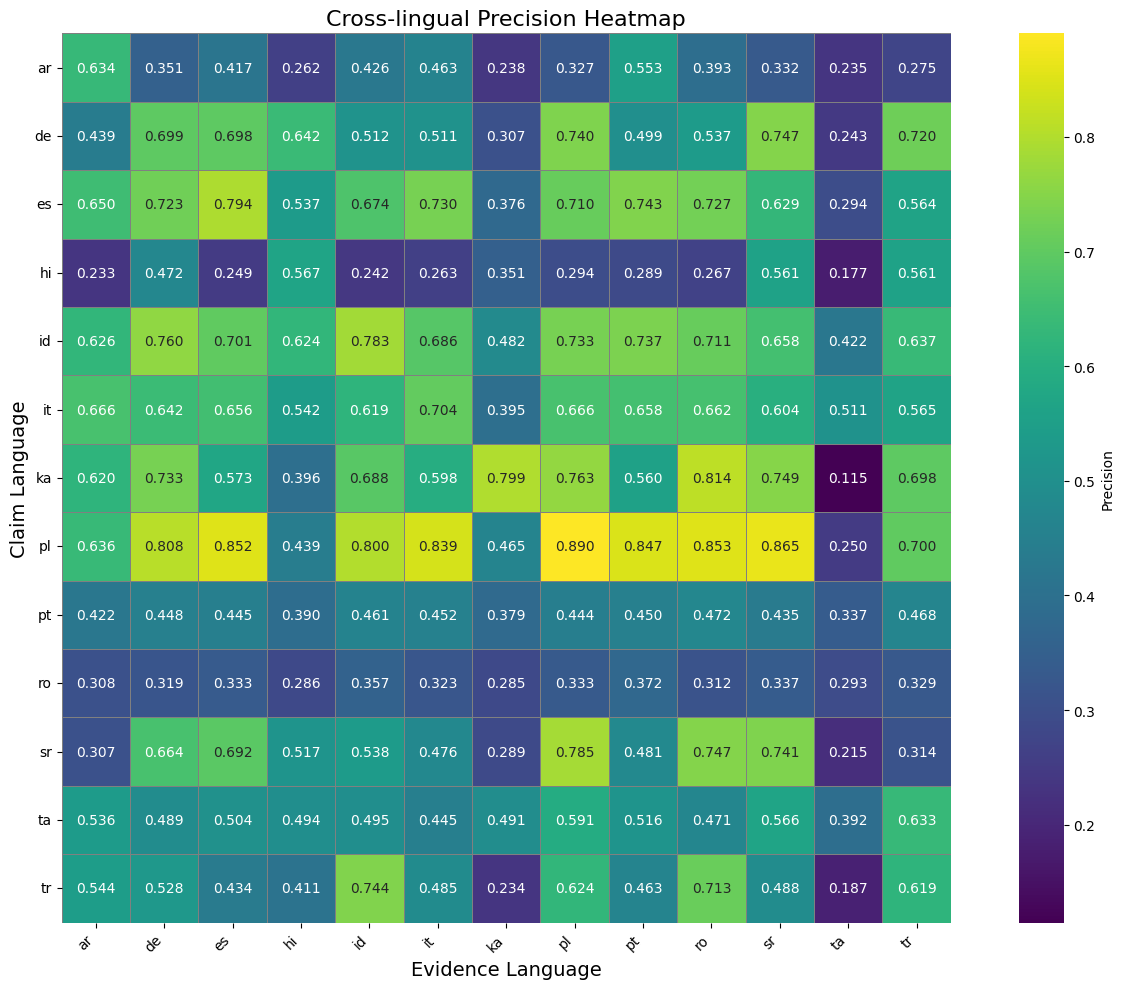

In [7]:
import os
import re
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_heatmap(scores, title="Cross-lingual Precision Heatmap"):
    """
    scores: dict of dict, example:
        {
            "hi": {"original": 0.72, "tr": 0.68},
            "tr": {"original": 0.70, "de": 0.61},
        }
    """

    # Collect sorted unique languages
    claim_langs = sorted(scores.keys())            # row order
    evidence_langs = sorted(
        {ev for row in scores.values() for ev in row.keys()}
    )                                              # column order

    # Build matrix
    matrix = []
    for cl in claim_langs:
        row_vals = []
        for ev in evidence_langs:
            row_vals.append(scores[cl].get(ev, np.nan))
        matrix.append(row_vals)

    # Convert to DataFrame
    df = pd.DataFrame(matrix, index=claim_langs, columns=evidence_langs)

    plt.figure(figsize=(14, 10))

    ax = sns.heatmap(
        df,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={'label': 'Precision'},
        square=True
    )

    plt.title(title, fontsize=16)
    plt.xlabel("Evidence Language", fontsize=14)
    plt.ylabel("Claim Language", fontsize=14)

    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()


# --------------------------
# Example usage
# --------------------------

# After running extraction:
# scores = collect_macro_f1_scores(base_dir)

# Plot
# plot_heatmap(scores)

def extract_macro_f1(text):
    """
    Robust extraction of macro-F1 from classification_report text.
    Handles arbitrary spacing and indentation.
    """
    for line in text.splitlines():
        stripped = line.strip().lower()
        if stripped.startswith("macro avg"):
            
            # Extract only numbers from the line
            nums = []
            for token in line.replace(",", " ").split():
                # accept floats like 0.5444
                try:
                    nums.append(float(token))
                except ValueError:
                    continue

            # nums = [precision, recall, f1, support]
            if len(nums) >= 3:
                return nums[0]  # F1-score

    return None


def collect_macro_f1_scores(base_dir):
    """
    Walk through directory and collect macro-F1 from metric files.

    base_dir example:
        outputs/xfact/Indomain/llama3/web_retrieval/

    Expected file format:
        metrics_<claimLang>_<evidenceLang>.txt
    """
    base_dir = Path(base_dir)
    results = defaultdict(dict)

    pattern = re.compile(r"metrics_(\w+)_(\w+)\.txt")

    for root, dirs, files in os.walk(base_dir):
        for f in files:
            m = pattern.match(f)
            if not m:
                continue

            claim_lang, evidence_lang = m.group(1), m.group(2)
            if evidence_lang == "original":
                evidence_lang = claim_lang
            file_path = Path(root) / f

            with open(file_path, "r", encoding="utf-8") as fp:
                text = fp.read()

            macro_f1 = extract_macro_f1(text)
            if macro_f1 is not None:
                results[claim_lang][evidence_lang] = macro_f1
            else:
                print(f"Warning: No macro F1 found in {file_path}")

    return results


# =======================
# EXAMPLE USAGE
# =======================

base_dir = "../outputs/xfact/Indomain/mistral/sentence_chunking"
scores = collect_macro_f1_scores(base_dir)

plot_heatmap(scores)

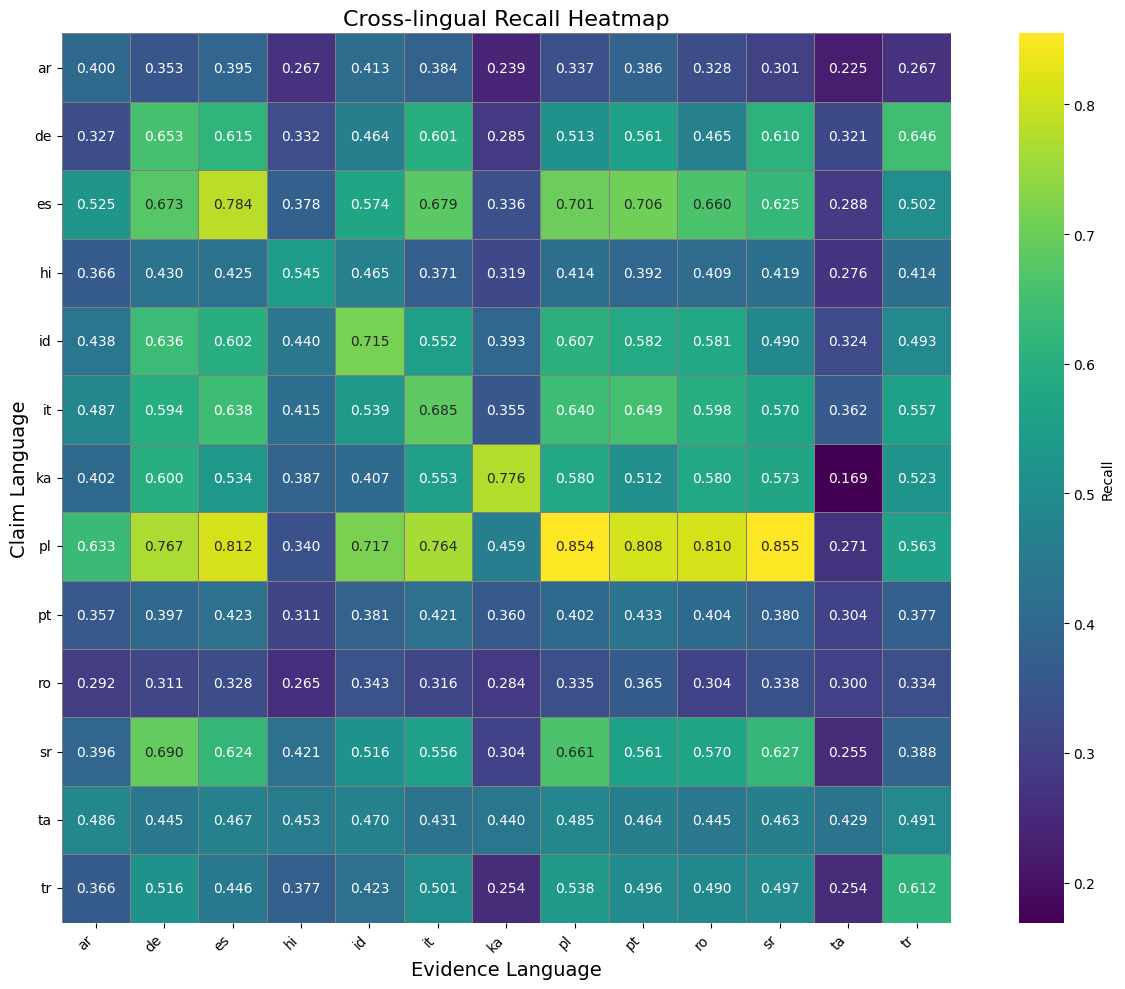

In [8]:
import os
import re
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_heatmap(scores, title="Cross-lingual Recall Heatmap"):
    """
    scores: dict of dict, example:
        {
            "hi": {"original": 0.72, "tr": 0.68},
            "tr": {"original": 0.70, "de": 0.61},
        }
    """

    # Collect sorted unique languages
    claim_langs = sorted(scores.keys())            # row order
    evidence_langs = sorted(
        {ev for row in scores.values() for ev in row.keys()}
    )                                              # column order

    # Build matrix
    matrix = []
    for cl in claim_langs:
        row_vals = []
        for ev in evidence_langs:
            row_vals.append(scores[cl].get(ev, np.nan))
        matrix.append(row_vals)

    # Convert to DataFrame
    df = pd.DataFrame(matrix, index=claim_langs, columns=evidence_langs)

    plt.figure(figsize=(14, 10))

    ax = sns.heatmap(
        df,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={'label': 'Recall'},
        square=True
    )

    plt.title(title, fontsize=16)
    plt.xlabel("Evidence Language", fontsize=14)
    plt.ylabel("Claim Language", fontsize=14)

    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()


# --------------------------
# Example usage
# --------------------------

# After running extraction:
# scores = collect_macro_f1_scores(base_dir)

# Plot
# plot_heatmap(scores)

def extract_macro_f1(text):
    """
    Robust extraction of macro-F1 from classification_report text.
    Handles arbitrary spacing and indentation.
    """
    for line in text.splitlines():
        stripped = line.strip().lower()
        if stripped.startswith("macro avg"):
            
            # Extract only numbers from the line
            nums = []
            for token in line.replace(",", " ").split():
                # accept floats like 0.5444
                try:
                    nums.append(float(token))
                except ValueError:
                    continue

            # nums = [precision, recall, f1, support]
            if len(nums) >= 3:
                return nums[1]  # F1-score

    return None


def collect_macro_f1_scores(base_dir):
    """
    Walk through directory and collect macro-F1 from metric files.

    base_dir example:
        outputs/xfact/Indomain/llama3/web_retrieval/

    Expected file format:
        metrics_<claimLang>_<evidenceLang>.txt
    """
    base_dir = Path(base_dir)
    results = defaultdict(dict)

    pattern = re.compile(r"metrics_(\w+)_(\w+)\.txt")

    for root, dirs, files in os.walk(base_dir):
        for f in files:
            m = pattern.match(f)
            if not m:
                continue

            claim_lang, evidence_lang = m.group(1), m.group(2)
            if evidence_lang == "original":
                evidence_lang = claim_lang
            file_path = Path(root) / f

            with open(file_path, "r", encoding="utf-8") as fp:
                text = fp.read()

            macro_f1 = extract_macro_f1(text)
            if macro_f1 is not None:
                results[claim_lang][evidence_lang] = macro_f1
            else:
                print(f"Warning: No macro F1 found in {file_path}")

    return results


# =======================
# EXAMPLE USAGE
# =======================

base_dir = "../outputs/xfact/Indomain/mistral/sentence_chunking"
scores = collect_macro_f1_scores(base_dir)

plot_heatmap(scores)